# Data Analysis with Python

Today we will look at two things:
1. Regression analysis with scikit-learn.
2. Neural networks in PyTorch.

In [ ]:
import sys

## Section 1: Regression in scikit-learn

In [ ]:
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

We will be looking at [Data on Energy](https://github.com/owid/energy-data?tab=readme-ov-file) by [Our World in Data](https://ourworldindata.org).

In [ ]:
dat_src = pd.read_csv("https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv")

The pandas.head function returns a bunch of NaNs so I returned some rows further down to give an idea of the data. Look at the [data dictionary](https://github.com/owid/energy-data/blob/master/owid-energy-codebook.csv) for a more descriptive explanation of the columns.

In [ ]:
dat_src.shape

We will subset into annual data from the US and [BRICS](https://en.wikipedia.org/wiki/BRICS) countries since 2000. We will put our focus on major energy types to evaluate any association between population and GDP with adoption of low carbon energy.

In [ ]:
countries = ["United States", "Brazil", "Russia", "India", "China", "South Africa"]
variables = [
      "country",
      "year",
      "population",
      "gdp",
      "electricity_demand",
      "electricity_generation",
      "low_carbon_consumption",
      "low_carbon_electricity",
    ]
dat = dat_src[dat_src["country"].isin(countries) & (dat_src["year"] >= 2000)].loc[:, variables]
dat.shape

In [ ]:
dat

In [ ]:
# generate figure
plt.figure()

# loop over all countries
for country in countries:
  dat_plt = dat[(dat["country"] == country)]
  plt.plot(dat_plt["year"], dat_plt["low_carbon_consumption"], label=country)

# stuff to make it pretty
plt.xlabel("Year")
plt.ylabel("Clean Energy Consumption (TWh)")
plt.title("US & BRICS Clean Energy Consumption")
plt.legend(loc="upper left")
plt.grid(zorder=0, linestyle='--', alpha=0.5)

plt.show()

Now let's see if there is a relationship between low carbon (i.e., "clean") energy consumption and GDP. We will need to normalize both per capita. Go ahead and create both variables now. Reminder energy use is reported as TWh and we would like to keep it at kWh when reporting per capita (i.e., multiply by `1e9`).

In [ ]:
### TODO


Let's re-create the plot above but showing how the clean energy consumption varies as a function of GDP per capita. You can copy-and-paste the code (or we encourage you to use your own). If you copy the above you'll need to switch the function from `plt.plot` to `plt.scatter`.

In [ ]:
### TODO

What do we notice? Let's analyze and quantify the linear relationship of the amount of clean energy consumption as a function of GDP per capita in the US. In the scikit-learn library there is a [linear regression](https://scikit-learn.org/stable/modules/linear_model.html) model function.

$\hat{y} = \beta_0 + \sum \beta_i X_i + ϵ$

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score

dat_train = dat[dat["country"] == "United States"]

# clean x
x_train = dat_train.loc[:, "gdp_per_capita"]
x_train = x_train.fillna(x_train.median())
x_train = np.array(x_train).reshape(-1, 1)

# clean y
y_train = dat_train.loc[:, "ceu_per_capita"]
y_train = y_train.fillna(y_train.median())
y_train = np.array(y_train).reshape(-1, 1)

glm = linear_model.LinearRegression()
glm.fit(x_train, y_train)

y_predict = glm.predict(x_train)

# The coefficients
print("Slope: %.2f" % glm.coef_[0][0])
print("Intercept: %.2f" % glm.intercept_[0])
print("R2: %.2f" % r2_score(y_train, y_predict)) # 1 is perfect prediction

Now let's visualize this and overlay it on top of the observed data points. You can create a range of $X$ values (e.g., [`np.arange`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)) then feed it into your model to get its predicted outcome and line plot that. Alternatively you can use the slope and intercept and plot a line that way (e.g., [`plt.axline`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axline.html)).

In [ ]:
x_predict = np.expand_dims(np.arange(40000, 80000, 10000), axis=1)
y_predict = glm.predict(x_predict)

# generate figure
plt.figure()

plt.scatter(x_train, y_train, label="United States")
plt.plot(x_predict, y_predict, color="blue", linewidth=2)

# stuff to make it pretty
plt.xlabel("GDP ($)")
plt.ylabel("Clean Energy Consumption (kWh)")
plt.title("US Clean Energy Consumption vs GDP")
#plt.legend(loc="upper left")
plt.grid(zorder=0, linestyle='--', alpha=0.5)

plt.show()

Now let's look at a binary outcome and model that versus a numerical feature input. Specifically, let's see if we can use logistic regression to identify an energy independent (i.e., net energy exporting) country from an energy dependent (i.e., net energy importing) country. The classification variable is `Net electricity imports as a share of demand - Electricity imports minus exports, measured as a percentage of total electricity demand.` so 100% implies a full net importer of energy needs and -100% implies a full net exporter of energy.

In [ ]:
variables = [
      "net_elec_imports_share_demand",
      "population",
      "gdp",
      "biofuel_cons_per_capita",
      #"coal_cons_per_capita",
      #"gas_energy_per_capita",
      "hydro_energy_per_capita",
      "nuclear_energy_per_capita",
      #"oil_energy_per_capita",
      "solar_energy_per_capita",
      "wind_energy_per_capita",
    ]
dat = dat_src.loc[:, variables]
dat = dat.dropna()

dat["gdp_per_capita"] = dat["gdp"] / dat["population"]

dat.shape

In [ ]:
dat.head()

In [ ]:
y = np.array(dat["net_elec_imports_share_demand"])
print([
    y.mean(),
    np.median(y),
    y.std(),
    y.min(),
    y.max(),
])

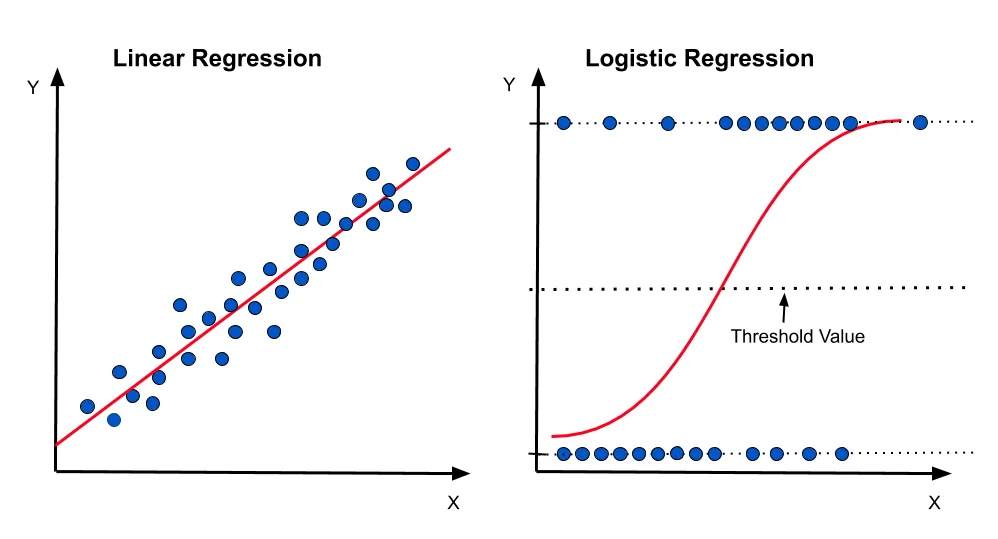

Logistic regression is similar in form but has a logit function applied to the output to get the shape above on the right.

$\ln \left( \frac{p(x)}{1-p(x)} \right) = \beta_0 + \sum \beta_i X_i + ϵ$

Now let's clean up the data and use the [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) function in scikit-learn. Typically to test the performance of your classifier you want to hold out a subset of your data to evaluate the classifier's performance. The use of the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function makes this easy.

In [ ]:
from sklearn.model_selection import train_test_split

# clean y
y = np.where(dat["net_elec_imports_share_demand"] > 0, 1, 0)

# clean x
X = dat.iloc[:, 3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, shuffle=True)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

The next part is the actual application of the regression. The $\beta$ coefficients associated with each feature are displayed.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

for i, var in enumerate(X_train.columns):
  print("%s: %.32f" % (var, np.exp(clf.coef_[0, i])))

y_pred = clf.predict(X_test)

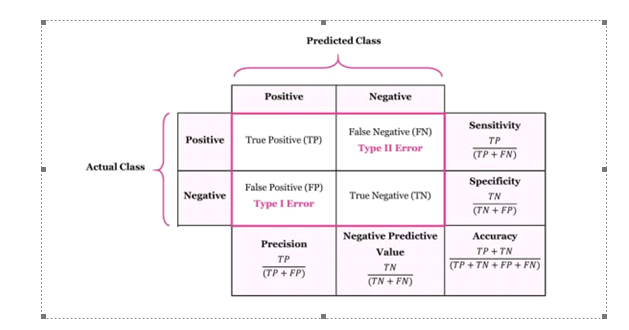

$\text{Precision} = \frac{TP}{TP+FP}$ or $\text{Recall} = \frac{TP}{TP+FN}$

In [ ]:
from sklearn import metrics

print(
    metrics.classification_report(y_test, y_pred, target_names=["importer", "exporter"])
  )

In [ ]:
from sklearn import metrics

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=("Logistic Regression, AUC=%.2f" % auc))
plt.axline((0, 0), slope=1, color="black", linestyle='--', alpha=0.5)

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Performance")
plt.legend(loc="lower right")
plt.grid(zorder=0, linestyle='--', alpha=0.5)

plt.show()

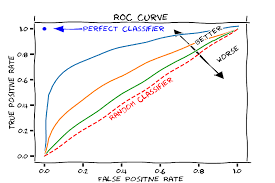

"In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding." (DOI: [10.1097/JTO.0b013e3181ec173d](https://doi.org/10.1097/JTO.0b013e3181ec173d))



## Section 2: Neural networks in PyTorch

In [ ]:
print(dat_src.info(verbose=True))

In [ ]:
import os
import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
y = np.where(dat_src["net_elec_imports_share_demand"] > 0, 1, 0)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
print(y.shape)

print(dat_src.shape)
X = dat_src.drop(columns=[
      "country",
      "year",
      "iso_code",
      "net_elec_imports_share_demand",
    ])
X = torch.tensor(X.to_numpy(), dtype=torch.float32)
X = torch.nan_to_num(X)
print(X.shape)

In [ ]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(125, 150),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(150, 1),
        )
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
          if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            #nn.init.normal_(m.weight, mean=0.0, std=1.0)

    def forward(self, x):
        x = self.block1(x)
        x = self.sigmoid(x)
        return x

The training boilerplate function below courtesy of [Jason Brownlee](https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/).

In [ ]:
import copy

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    #loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-6)

    n_epochs = 10 # number of epochs to run
    batch_size = 100 # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Training on {device}.\n")

model = MyNN()#.to(device)
print(model)

print("This model has %d parameters." % sum([x.reshape(-1).shape[0] for x in model.parameters()]))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

In [ ]:
model.eval()
with torch.no_grad():
  p = model(X_test)
  y_pred_roc = p.squeeze(-1).detach().numpy()
  y_test_roc = y_test.squeeze(-1).detach().numpy()

  fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test_roc, y_pred_roc)
  auc_roc = metrics.roc_auc_score(y_test_roc, y_pred_roc)
  plt.plot(fpr_roc, tpr_roc, label=("NN, AUC=%.2f" % auc_roc))

  plt.plot(fpr, tpr, label=("Logistic Regression, AUC=%.2f" % auc))
  plt.axline((0, 0), slope=1, color="black", linestyle='--', alpha=0.5)

  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.title("ROC Performance")
  plt.legend(loc="lower right")
  plt.grid(zorder=0, linestyle='--', alpha=0.5)

  plt.show()